In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm, factorial
from scipy.integrate import quad
import random

class RotationalWignerSampler:
    """
    Class for Wigner sampling of rotational quantum states
    """
    
    def __init__(self, moment_of_inertia=1.0, hbar=1.0):
        """
        Initialize the sampler
        
        Parameters:
        - moment_of_inertia: Moment of inertia (atomic units or SI)
        - hbar: Reduced Planck constant (set to 1 for atomic units)
        """
        self.I = moment_of_inertia
        self.hbar = hbar
        
    def spherical_harmonic_prob(self, theta, phi, J, M):
        """
        Calculate |Y_J^M(theta, phi)|^2 probability density
        """
        Y = sph_harm(M, J, phi, theta)
        return np.abs(Y)**2
    
    def sample_angles(self, J, M, n_samples=1000):
        """
        Sample angles (theta, phi) from |Y_J^M|^2 distribution
        using acceptance-rejection method
        """
        theta_samples = []
        phi_samples = []
        
        # Find maximum of probability density for normalization
        theta_test = np.linspace(0, np.pi, 100)
        phi_test = np.linspace(0, 2*np.pi, 100)
        theta_grid, phi_grid = np.meshgrid(theta_test, phi_test)
        
        prob_max = 0
        for i in range(len(theta_test)):
            for j in range(len(phi_test)):
                prob = self.spherical_harmonic_prob(theta_test[i], phi_test[j], J, M)
                prob_max = max(prob_max, prob * np.sin(theta_test[i]))
        
        # Acceptance-rejection sampling
        count = 0
        while count < n_samples:
            # Sample candidate angles
            theta_cand = np.random.uniform(0, np.pi)
            phi_cand = np.random.uniform(0, 2*np.pi)
            
            # Calculate probability density (including sin(theta) factor)
            prob = self.spherical_harmonic_prob(theta_cand, phi_cand, J, M) * np.sin(theta_cand)
            
            # Accept or reject
            if np.random.uniform(0, prob_max) < prob:
                theta_samples.append(theta_cand)
                phi_samples.append(phi_cand)
                count += 1
                
        return np.array(theta_samples), np.array(phi_samples)
    
    def sample_angular_momenta(self, J, n_samples):
        """
        Sample angular momentum components with quantum uncertainties
        
        For a rigid rotor in state |J,M>, we have:
        - <L_z> = M*hbar
        - <L^2> = J(J+1)*hbar^2
        - Uncertainty in L_x, L_y due to quantum mechanics
        """
        # Classical angular momentum magnitude
        L_magnitude = self.hbar * np.sqrt(J * (J + 1))
        
        # Sample L_z values (these should be close to M*hbar with quantum uncertainty)
        L_z_mean = 0  # We'll set M*hbar later
        L_z_std = self.hbar * np.sqrt(J * (J + 1) / 3)  # Rough estimate of uncertainty
        
        # For Wigner sampling, we need to include quantum uncertainties
        # This is a simplified approach - full Wigner function would be more complex
        L_x = np.random.normal(0, L_z_std, n_samples)
        L_y = np.random.normal(0, L_z_std, n_samples)
        L_z = np.random.normal(0, L_z_std, n_samples)
        
        # Normalize to correct magnitude (approximately)
        L_total = np.sqrt(L_x**2 + L_y**2 + L_z**2)
        factor = L_magnitude / L_total
        
        L_x *= factor
        L_y *= factor  
        L_z *= factor
        
        return L_x, L_y, L_z
    
    def angles_to_cartesian_orientation(self, theta, phi):
        """
        Convert spherical angles to Cartesian unit vector
        (orientation of molecular axis)
        """
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        
        return x, y, z
    
    def angular_momentum_to_velocity(self, L_x, L_y, L_z, orientation_x, orientation_y, orientation_z):
        """
        Convert angular momentum to angular velocity
        
        For a diatomic molecule rotating about axes perpendicular to molecular axis:
        ω = L / I (for rotation perpendicular to molecular axis)
        """
        # Angular velocity components
        omega_x = L_x / self.I
        omega_y = L_y / self.I
        omega_z = L_z / self.I
        
        return omega_x, omega_y, omega_z
    
    def sample_rotational_state(self, J, M, n_samples=1000):
        """
        Complete Wigner sampling for rotational state |J,M>
        
        Returns:
        - Orientations (Cartesian unit vectors)
        - Angular velocities
        """
        # Sample angles
        theta, phi = self.sample_angles(J, M, n_samples)
        
        # Convert to Cartesian orientations
        orient_x, orient_y, orient_z = self.angles_to_cartesian_orientation(theta, phi)
        
        # Sample angular momenta
        L_x, L_y, L_z = self.sample_angular_momenta(J, n_samples)
        
        # Add the M*hbar component to L_z
        L_z += M * self.hbar
        
        # Convert to angular velocities
        omega_x, omega_y, omega_z = self.angular_momentum_to_velocity(
            L_x, L_y, L_z, orient_x, orient_y, orient_z
        )
        
        return {
            'orientations': np.column_stack([orient_x, orient_y, orient_z]),
            'angular_velocities': np.column_stack([omega_x, omega_y, omega_z]),
            'angles': np.column_stack([theta, phi]),
            'angular_momenta': np.column_stack([L_x, L_y, L_z])
        }

# Demonstration
def demonstrate_wigner_sampling():
    """
    Demonstrate the Wigner sampling for different J,M states
    """
    
    # Initialize sampler (using moment of inertia for H2 in atomic units as example)
    I_H2 = 0.46  # atomic units
    sampler = RotationalWignerSampler(moment_of_inertia=I_H2)
    
    # Sample different rotational states
    states_to_sample = [(0, 0), (1, 0), (1, 1), (2, 0), (2, 1)]
    n_samples = 1000
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (J, M) in enumerate(states_to_sample):
        print(f"\nSampling J={J}, M={M} state...")
        
        # Perform Wigner sampling
        results = sampler.sample_rotational_state(J, M, n_samples)
        
        # Plot angular distribution
        theta = results['angles'][:, 0]
        phi = results['angles'][:, 1]
        
        # Convert to 2D histogram for visualization
        ax = axes[i]
        hist, theta_edges, phi_edges = np.histogram2d(theta, phi, bins=20)
        
        im = ax.imshow(hist.T, extent=[0, np.pi, 0, 2*np.pi], 
                      aspect='auto', origin='lower', cmap='Blues')
        ax.set_xlabel('θ (radians)')
        ax.set_ylabel('φ (radians)')
        ax.set_title(f'J={J}, M={M} Angular Distribution')
        
        # Print some statistics
        L_mag = np.linalg.norm(results['angular_momenta'], axis=1)
        L_z_avg = np.mean(results['angular_momenta'][:, 2])
        
        print(f"  Average |L|: {np.mean(L_mag):.3f} (expected: {np.sqrt(J*(J+1)):.3f})")
        print(f"  Average L_z: {L_z_avg:.3f} (expected: {M:.3f})")
    
    # Remove unused subplot
    if len(states_to_sample) < len(axes):
        axes[-1].remove()
    
    plt.tight_layout()
    plt.show()
    
    # Demonstrate conversion to MD initial conditions
    print("\n" + "="*50)
    print("EXAMPLE: Initial conditions for MD simulation")
    print("="*50)
    
    J, M = 2, 1
    results = sampler.sample_rotational_state(J, M, n_samples=5)  # Just 5 samples for demo
    
    print(f"\nRotational state: J={J}, M={M}")
    print("Sample initial conditions for MD:")
    print("\nMolecule | Orientation (x,y,z) | Angular Velocity (ωx,ωy,ωz)")
    print("-" * 70)
    
    for i in range(5):
        orient = results['orientations'][i]
        omega = results['angular_velocities'][i]
        print(f"   {i+1:2d}    | ({orient[0]:6.3f},{orient[1]:6.3f},{orient[2]:6.3f}) | "
              f"({omega[0]:8.3f},{omega[1]:8.3f},{omega[2]:8.3f})")
    
    return results




Sampling J=0, M=0 state...
  Average |L|: nan (expected: 0.000)
  Average L_z: nan (expected: 0.000)

Sampling J=1, M=0 state...
  Average |L|: 1.414 (expected: 1.414)
  Average L_z: -0.001 (expected: 0.000)

Sampling J=1, M=1 state...
  Average |L|: 1.658 (expected: 1.414)
  Average L_z: 1.012 (expected: 1.000)

Sampling J=2, M=0 state...
  Average |L|: 2.449 (expected: 2.449)
  Average L_z: -0.022 (expected: 0.000)

Sampling J=2, M=1 state...
  Average |L|: 2.596 (expected: 2.449)
  Average L_z: 1.026 (expected: 1.000)


/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/ipykernel_33628/4010454157.py:27: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y = sph_harm(M, J, phi, theta)
/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/ipykernel_33628/4010454157.py:91: RuntimeWarning: invalid value encountered in divide
  factor = L_magnitude / L_total


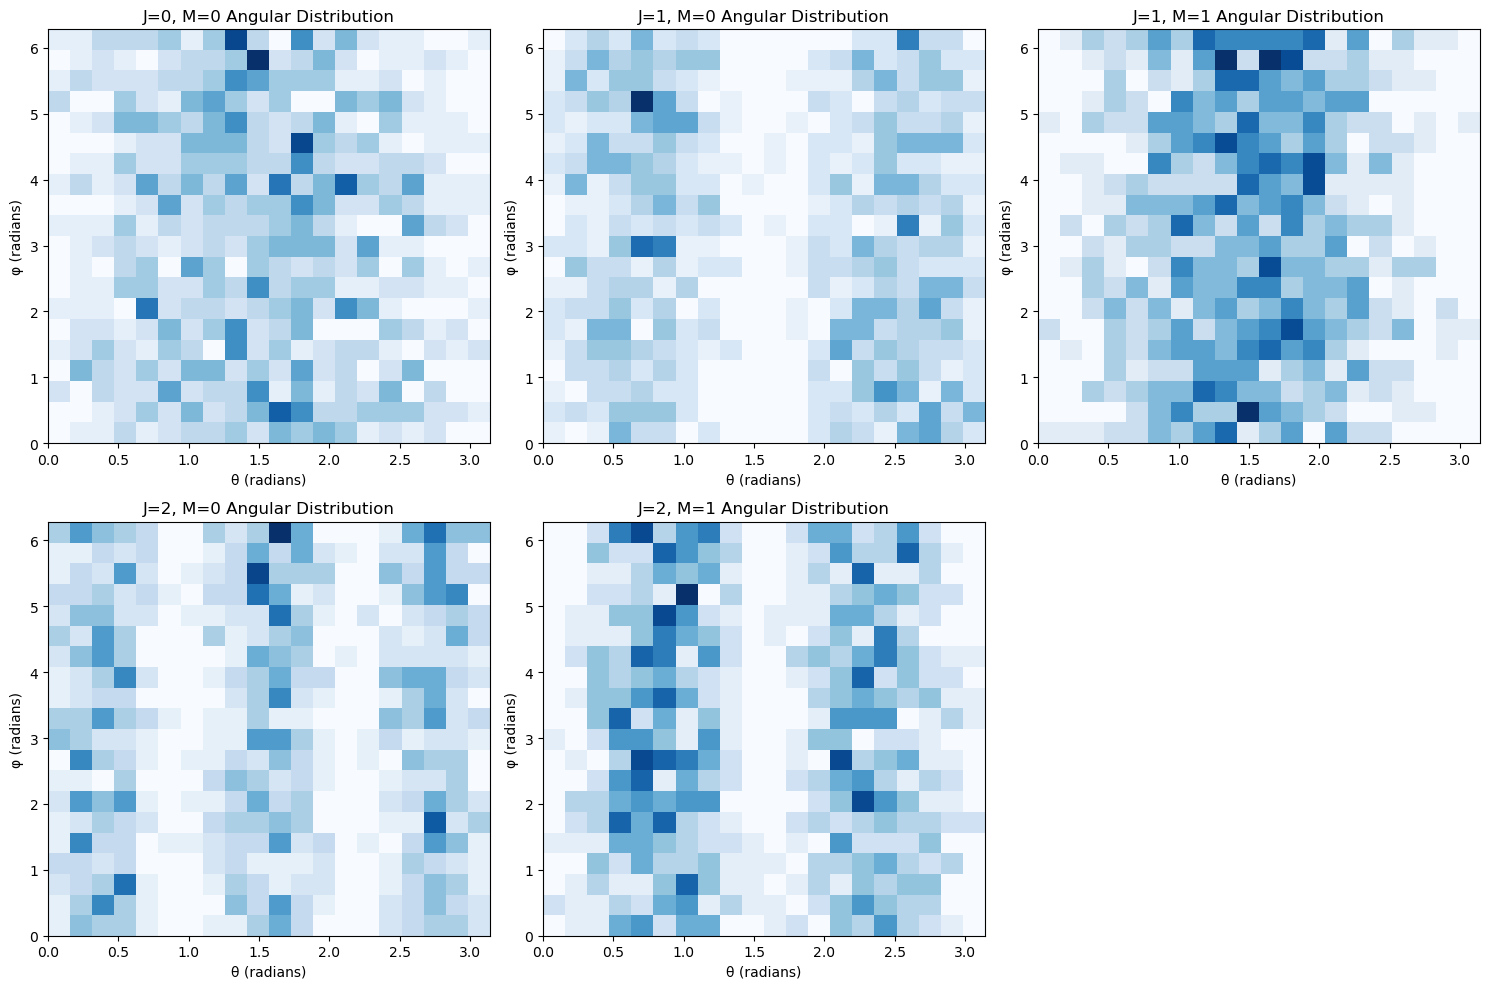


EXAMPLE: Initial conditions for MD simulation

Rotational state: J=2, M=1
Sample initial conditions for MD:

Molecule | Orientation (x,y,z) | Angular Velocity (ωx,ωy,ωz)
----------------------------------------------------------------------
    1    | ( 0.488,-0.768,-0.414) | (   1.782,   4.741,   3.818)
    2    | ( 0.256,-0.516, 0.818) | (   0.437,  -4.470,  -0.687)
    3    | ( 0.412,-0.375,-0.830) | (   1.413,   4.722,   4.190)
    4    | ( 0.766,-0.436, 0.472) | (  -4.664,  -0.222,  -0.385)
    5    | (-0.847,-0.372, 0.379) | (   5.017,  -1.423,   1.097)

EXAMPLE: Multiple diatomic molecules
Molecule 1 (J=1, M=0):
  Orientation: [ 0.68441227 -0.31113678  0.65937376]
  Angular velocity: [-2.88769662 -0.36525687 -0.98974315]

Molecule 2 (J=2, M=1):
  Orientation: [-0.32450161 -0.12400077 -0.93772198]
  Angular velocity: [ 0.86853461 -5.25190208  2.31014721]

These can be used as initial conditions in your cavity QED MD simulation!


In [2]:
# Run the demonstration
if __name__ == "__main__":
    results = demonstrate_wigner_sampling()
    
    # Additional example: Multiple molecules
    print("\n" + "="*50)
    print("EXAMPLE: Multiple diatomic molecules")
    print("="*50)
    
    sampler = RotationalWignerSampler(moment_of_inertia=0.46)
    
    # Sample two molecules in different states
    mol1_results = sampler.sample_rotational_state(J=1, M=0, n_samples=1)
    mol2_results = sampler.sample_rotational_state(J=2, M=1, n_samples=1)
    
    print("Molecule 1 (J=1, M=0):")
    print(f"  Orientation: {mol1_results['orientations'][0]}")
    print(f"  Angular velocity: {mol1_results['angular_velocities'][0]}")
    
    print("\nMolecule 2 (J=2, M=1):")
    print(f"  Orientation: {mol2_results['orientations'][0]}")
    print(f"  Angular velocity: {mol2_results['angular_velocities'][0]}")
    
    print("\nThese can be used as initial conditions in your cavity QED MD simulation!")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from scipy.integrate import dblquad
from scipy.interpolate import RegularGridInterpolator

class CavityDressedRotationalSampler:
    """
    Wigner sampling for cavity-dressed rotational states
    """
    
    def __init__(self, moment_of_inertia=1.0, hbar=1.0):
        self.I = moment_of_inertia
        self.hbar = hbar
        self.B = hbar**2 / (2 * moment_of_inertia)  # Rotational constant
        
    def example_cavity_potential(self, theta, phi, coupling_strength=0.1):
        """
        Example cavity potential - you would replace this with your ab initio results
        
        This example assumes:
        - Cavity mode polarized along z-axis
        - Coupling ∝ (μ⃗ · E⃗_cavity)² where μ⃗ is transition dipole
        - For demonstration: V ∝ cos²(θ) (alignment along cavity axis)
        """
        # Simple orientational coupling
        V_orient = coupling_strength * self.B * (3 * np.cos(theta)**2 - 1)
        
        # Could add more complex angular dependence based on your cavity geometry
        # V_orient += other_terms * np.sin(theta)**2 * np.cos(2*phi)  # example
        
        return V_orient
    
    def setup_grid(self, n_theta=50, n_phi=50):
        """
        Setup angular grid for numerical solution
        """
        self.theta_grid = np.linspace(0, np.pi, n_theta)
        self.phi_grid = np.linspace(0, 2*np.pi, n_phi)
        self.dtheta = self.theta_grid[1] - self.theta_grid[0]
        self.dphi = self.phi_grid[1] - self.phi_grid[0]
        
        # 2D meshgrid
        self.theta_mesh, self.phi_mesh = np.meshgrid(self.theta_grid, self.phi_grid, indexing='ij')
        
        # Flattened for matrix operations
        self.theta_flat = self.theta_mesh.flatten()
        self.phi_flat = self.phi_mesh.flatten()
        self.n_points = len(self.theta_flat)
        
    def build_kinetic_matrix(self):
        """
        Build kinetic energy matrix for rotational motion
        Using finite difference for the angular Laplacian
        """
        n = self.n_points
        n_theta, n_phi = len(self.theta_grid), len(self.phi_grid)
        
        # This is a simplified finite difference approach
        # Full implementation would use proper spherical harmonics basis
        
        # For demonstration, use a simple approximation
        T_matrix = np.zeros((n, n))
        
        for i in range(n):
            # Get 2D indices
            i_theta = i // n_phi
            i_phi = i % n_phi
            
            theta = self.theta_grid[i_theta]
            
            # Diagonal term (simplified)
            T_matrix[i, i] = self.B * (2/self.dtheta**2 + 2/(np.sin(theta)**2 * self.dphi**2))
            
            # Off-diagonal terms (theta direction)
            if i_theta > 0:
                j = (i_theta-1) * n_phi + i_phi
                T_matrix[i, j] = -self.B / self.dtheta**2
            if i_theta < n_theta-1:
                j = (i_theta+1) * n_phi + i_phi
                T_matrix[i, j] = -self.B / self.dtheta**2
                
            # Off-diagonal terms (phi direction, with periodicity)
            if np.sin(theta) > 0.1:  # Avoid singularity at poles
                # Previous phi
                j_phi = (i_phi - 1) % n_phi
                j = i_theta * n_phi + j_phi
                T_matrix[i, j] = -self.B / (np.sin(theta)**2 * self.dphi**2)
                
                # Next phi
                j_phi = (i_phi + 1) % n_phi
                j = i_theta * n_phi + j_phi
                T_matrix[i, j] = -self.B / (np.sin(theta)**2 * self.dphi**2)
        
        return T_matrix
    
    def build_potential_matrix(self, cavity_potential_func, **pot_kwargs):
        """
        Build potential energy matrix (diagonal)
        """
        V_values = cavity_potential_func(self.theta_flat, self.phi_flat, **pot_kwargs)
        return np.diag(V_values)
    
    def solve_dressed_states(self, cavity_potential_func, n_states=10, **pot_kwargs):
        """
        Solve for cavity-dressed rotational states
        """
        print("Setting up grid...")
        self.setup_grid()
        
        print("Building Hamiltonian matrices...")
        T_matrix = self.build_kinetic_matrix()
        V_matrix = self.build_potential_matrix(cavity_potential_func, **pot_kwargs)
        
        H_matrix = T_matrix + V_matrix
        
        print(f"Diagonalizing {self.n_points}x{self.n_points} Hamiltonian...")
        # Find lowest energy states
        eigenvalues, eigenvectors = eigsh(H_matrix, k=n_states, which='SA')
        
        # Reshape eigenvectors back to 2D grid
        wavefunctions_2d = []
        for i in range(n_states):
            wf_flat = eigenvectors[:, i]
            wf_2d = wf_flat.reshape(len(self.theta_grid), len(self.phi_grid))
            wavefunctions_2d.append(wf_2d)
        
        self.eigenvalues = eigenvalues
        self.wavefunctions_2d = wavefunctions_2d
        self.eigenvectors = eigenvectors
        
        return eigenvalues, wavefunctions_2d
    
    def sample_dressed_state(self, state_index, n_samples=1000):
        """
        Sample from a specific cavity-dressed rotational state
        """
        if not hasattr(self, 'wavefunctions_2d'):
            raise ValueError("Must solve dressed states first!")
        
        wf_2d = np.abs(self.wavefunctions_2d[state_index])**2
        
        # Normalize probability density (include sin(theta) factor)
        prob_density = wf_2d * np.sin(self.theta_mesh)
        prob_density /= np.sum(prob_density) * self.dtheta * self.dphi
        
        # Create interpolator for smooth sampling
        prob_interp = RegularGridInterpolator(
            (self.theta_grid, self.phi_grid), prob_density, 
            bounds_error=False, fill_value=0
        )
        
        # Sample using acceptance-rejection
        theta_samples = []
        phi_samples = []
        
        # Find maximum for normalization
        prob_max = np.max(prob_density)
        
        count = 0
        while count < n_samples:
            theta_cand = np.random.uniform(0, np.pi)
            phi_cand = np.random.uniform(0, 2*np.pi)
            
            prob = prob_interp([theta_cand, phi_cand])[0]
            
            if np.random.uniform(0, prob_max) < prob:
                theta_samples.append(theta_cand)
                phi_samples.append(phi_cand)
                count += 1
        
        theta_samples = np.array(theta_samples)
        phi_samples = np.array(phi_samples)
        
        # Convert to Cartesian orientations
        orient_x = np.sin(theta_samples) * np.cos(phi_samples)
        orient_y = np.sin(theta_samples) * np.sin(phi_samples)
        orient_z = np.cos(theta_samples)
        
        # Sample angular momenta (simplified - could be improved)
        # For dressed states, this becomes more complex
        energy = self.eigenvalues[state_index]
        
        # Estimate angular momentum from energy
        # This is approximate - full treatment would need momentum operators
        L_magnitude = np.sqrt(2 * self.I * abs(energy))
        
        # Sample angular momentum components
        L_x = np.random.normal(0, L_magnitude/np.sqrt(3), n_samples)
        L_y = np.random.normal(0, L_magnitude/np.sqrt(3), n_samples)
        L_z = np.random.normal(0, L_magnitude/np.sqrt(3), n_samples)
        
        # Normalize
        L_total = np.sqrt(L_x**2 + L_y**2 + L_z**2)
        factor = L_magnitude / L_total
        L_x *= factor
        L_y *= factor
        L_z *= factor
        
        # Convert to angular velocities
        omega_x = L_x / self.I
        omega_y = L_y / self.I
        omega_z = L_z / self.I
        
        return {
            'orientations': np.column_stack([orient_x, orient_y, orient_z]),
            'angular_velocities': np.column_stack([omega_x, omega_y, omega_z]),
            'angles': np.column_stack([theta_samples, phi_samples]),
            'angular_momenta': np.column_stack([L_x, L_y, L_z]),
            'energy': energy
        }

def demonstrate_cavity_dressed_sampling():
    """
    Demonstrate cavity-dressed rotational state sampling
    """
    # Initialize sampler
    I_H2 = 0.46  # H2 moment of inertia in atomic units
    sampler = CavityDressedRotationalSampler(moment_of_inertia=I_H2)
    
    # Solve for dressed states with different coupling strengths
    coupling_strengths = [0.0, 0.1, 0.3]  # In units of rotational constant
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, coupling in enumerate(coupling_strengths):
        print(f"\n{'='*50}")
        print(f"Coupling strength: {coupling:.1f} × B_rot")
        print('='*50)
        
        # Solve dressed states
        energies, wavefunctions = sampler.solve_dressed_states(
            sampler.example_cavity_potential, 
            n_states=6, 
            coupling_strength=coupling
        )
        
        print("Dressed state energies (in units of B_rot):")
        for j, E in enumerate(energies):
            print(f"  State {j}: {E/sampler.B:.3f}")
        
        # Plot ground state wavefunction
        ax1 = axes[0, i]
        wf = np.abs(wavefunctions[0])**2
        im1 = ax1.imshow(wf, extent=[0, 2*np.pi, 0, np.pi], 
                        aspect='auto', origin='lower', cmap='Blues')
        ax1.set_xlabel('φ (radians)')
        ax1.set_ylabel('θ (radians)')
        ax1.set_title(f'|ψ₀|² (coupling = {coupling:.1f}B)')
        
        # Plot first excited state
        ax2 = axes[1, i]
        if len(wavefunctions) > 1:
            wf1 = np.abs(wavefunctions[1])**2
            im2 = ax2.imshow(wf1, extent=[0, 2*np.pi, 0, np.pi], 
                            aspect='auto', origin='lower', cmap='Reds')
        ax2.set_xlabel('φ (radians)')
        ax2.set_ylabel('θ (radians)')
        ax2.set_title(f'|ψ₁|² (coupling = {coupling:.1f}B)')
        
        # Sample from ground state
        if i == 2:  # Only for strongest coupling
            print("\nSampling from ground dressed state:")
            samples = sampler.sample_dressed_state(0, n_samples=5)
            
            print("Sample initial conditions:")
            for j in range(5):
                orient = samples['orientations'][j]
                omega = samples['angular_velocities'][j]
                print(f"  Sample {j+1}: orientation=({orient[0]:.3f},{orient[1]:.3f},{orient[2]:.3f})")
                print(f"             ω=({omega[0]:.3f},{omega[1]:.3f},{omega[2]:.3f})")
    
    plt.tight_layout()
    plt.show()
    
    return sampler

# Alternative approach: Perturbative treatment
def perturbative_dressed_states(J_max=3, coupling_strength=0.1):
    """
    Demonstrate perturbative approach for weak cavity coupling
    """
    print(f"\n{'='*50}")
    print("PERTURBATIVE APPROACH")
    print('='*50)
    
    B_rot = 1.0  # Rotational constant
    
    # Build basis of free rotor states |J,M>
    basis_states = []
    for J in range(J_max + 1):
        for M in range(-J, J + 1):
            basis_states.append((J, M))
    
    n_basis = len(basis_states)
    print(f"Using {n_basis} basis states (J=0 to {J_max})")
    
    # Build Hamiltonian matrix
    H_matrix = np.zeros((n_basis, n_basis))
    
    # Free rotor energies (diagonal)
    for i, (J, M) in enumerate(basis_states):
        H_matrix[i, i] = B_rot * J * (J + 1)
    
    # Cavity coupling matrix elements (off-diagonal)
    # This would require calculating ⟨J',M'|V_cavity(θ,φ)|J,M⟩
    # For simplicity, assume some coupling pattern
    for i, (J1, M1) in enumerate(basis_states):
        for j, (J2, M2) in enumerate(basis_states):
            if i != j and abs(J1 - J2) <= 2:  # Selection rules
                # Example coupling matrix element
                coupling_element = coupling_strength * B_rot * np.exp(-abs(J1-J2))
                H_matrix[i, j] = coupling_element
    
    # Diagonalize
    eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
    
    print("\nPerturbed energy levels:")
    for i, E in enumerate(eigenvalues[:6]):
        print(f"  State {i}: {E:.4f} B_rot")
        
        # Show composition in terms of free rotor states
        coeffs = eigenvectors[:, i]
        print("    Composition:", end=" ")
        for j, coeff in enumerate(coeffs):
            if abs(coeff) > 0.1:
                J, M = basis_states[j]
                print(f"{coeff:.2f}|{J},{M}⟩", end=" ")
        print()
    
    return eigenvalues, eigenvectors, basis_states



Coupling strength: 0.0 × B_rot
Setting up grid...
Building Hamiltonian matrices...
Diagonalizing 2500x2500 Hamiltonian...


/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/ipykernel_33628/2143435254.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  T_matrix[i, i] = self.B * (2/self.dtheta**2 + 2/(np.sin(theta)**2 * self.dphi**2))


ArpackError: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.

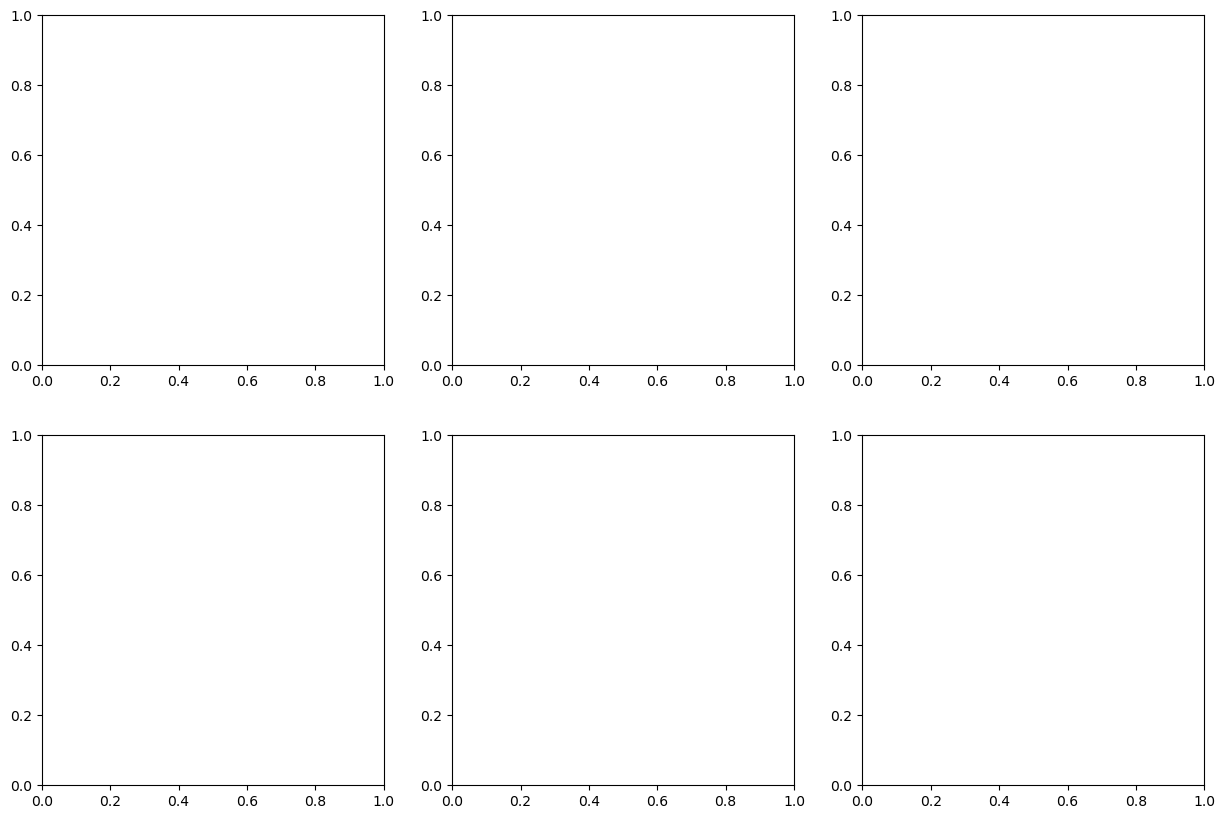

In [4]:

if __name__ == "__main__":
    # Run demonstrations
    sampler = demonstrate_cavity_dressed_sampling()
    perturbative_dressed_states()
    
    print(f"\n{'='*60}")
    print("SUMMARY: Approaches for cavity-dressed sampling")
    print('='*60)
    print("1. HINDERED ROTOR: Solve H = B J² + V_cavity(θ,φ) numerically")
    print("   - Best for moderate-to-strong coupling")
    print("   - Requires your ab initio V_cavity(θ,φ)")
    print("   - Most accurate but computationally intensive")
    print()
    print("2. PERTURBATIVE: Diagonalize in free rotor basis")
    print("   - Best for weak coupling")
    print("   - Faster computation")
    print("   - Need matrix elements ⟨J',M'|V_cavity|J,M⟩")
    print()
    print("3. SIMPLE CORRECTION: Use free rotor + energy shift")
    print("   - Simplest approach")
    print("   - Sample from |Y_J^M|² but with shifted energies")
    print("   - Good for very weak coupling")